# Import
Import libraries 

In [ ]:
import cv2
import time
import os, datetime
import shutil
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, applications, activations
from tensorflow.keras.layers import Conv3D ,BatchNormalization ,Activation, Input, ZeroPadding3D, MaxPooling3D, AveragePooling3D,GlobalAveragePooling3D, Flatten, Dense, Dropout, Add
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from skimage.transform import resize
import tensorflow.image as Image
import pickle

# Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/3DCNN_AD/' 

/content/drive/MyDrive/3DCNN_AD


# Functions

In [ ]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -200
    max = 200
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 64
    desired_height = 64
    # Get current depth
    current_depth = img.shape[2]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor,1), order=1)
    return img


# Sobel Filter
def sobel_filter(volume):
    for i in range(volume.shape[2]):
      volume[:,:,i,0] = ndimage.convolve( np.squeeze(volume[:, :, i]),weights=  0.2*np.array([[1,0,-1],[2,0,-2],[1,0,-1]]))
    return volume

# loG Filter

def loG_filter(volume):
    for i in range(volume.shape[2]):
      volume[:,:,i,0] = ndimage.convolve( np.squeeze(volume[:, :, i]),
                                          weights=  0.01*np.array([[0,1,1,2,2,2,1,1,0],[1,2,4,5,5,5,4,2,1],[1,4,5,3,0,3,5,4,1],
                                                              [2,5,3,-12,-24,-12,3,5,2], [2,5,0,-24,-40,-24,0,5,2],[2,5,3,-12,-24,-12,3,5,2],
                                                              [1,4,5,3,0,3,5,4,1],[1,2,4,5,5,5,4,2,1],[0,1,1,2,2,2,1,1,0]]))
    return volume


# change between loG and Sobel filter ( normalize -200 200)
# if no filter applyed normalize -1000 1000

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Resize width, height and depth
    volume = resize_volume(volume)
    # Filter 
    volume = sobel_filter(volume)
    # Normalize 
    volume = normalize(volume)
    return volume





# ONE TIME RUN

In [ ]:
#DONOT EXEC


# Unzip the dataset (zip file) in a temporary folder on the virtual machine.
!unzip ./AD_Axial_PD_T2_FSE_NII.zip -d /content/drive/MyDrive/3DCNN_AD/data_AD_NII
!unzip ./CN_Axial_PD_T2_FSE_NII.zip -d /content/drive/MyDrive/3DCNN_AD/data_CN_NII
!unzip ./MCI_Axial_PD_T2_FSE_NII.zip -d /content/drive/MyDrive/3DCNN_AD/data_MCI_NII

In [ ]:
#DONOT EXEC

#building paths for AD
inputdir = '/content/drive/MyDrive/3DCNN_AD/data_AD_NII/ADNI/' 
AD_scan_paths = []

list_outer = [ f for f in  os.listdir(inputdir)]
for f in list_outer: 
  path = inputdir + f 
  list_inner = [ f for f in  os.listdir(path)]
  for f_ in list_inner:
    path = inputdir + f + '/' + f_ + '/'
    list_inner_ = [ f for f in  os.listdir(path)]
    for f__ in list_inner_:
      path = inputdir + f + '/' + f_ + '/' + f__ + '/'
      list_inner__ = [ f for f in  os.listdir(path)]
      for f___ in list_inner__: 
        path = inputdir + f + '/' + f_ + '/' + f__ + '/' + f___ + '/'
        list_subs = [ s for s in  os.listdir(path)]
        for s in list_subs:
          path = inputdir + f + '/' + f_ + '/' + f__ + '/' + f___ + '/' + s 
          AD_scan_paths.append(path)


#building paths for CN
inputdir = '/content/drive/MyDrive/3DCNN_AD/data_CN_NII/ADNI/' 
CN_scan_paths = []

list_outer = [ f for f in  os.listdir(inputdir)]
for f in list_outer: 
  path = inputdir + f 
  list_inner = [ f for f in  os.listdir(path)]
  for f_ in list_inner:
    path = inputdir + f + '/' + f_ + '/'
    list_inner_ = [ f for f in  os.listdir(path)]
    for f__ in list_inner_:
      path = inputdir + f + '/' + f_ + '/' + f__ + '/'
      list_inner__ = [ f for f in  os.listdir(path)]
      for f___ in list_inner__: 
        path = inputdir + f + '/' + f_ + '/' + f__ + '/' + f___ + '/'
        list_subs = [ s for s in  os.listdir(path)]
        for s in list_subs:
          path = inputdir + f + '/' + f_ + '/' + f__ + '/' + f___ + '/' + s 
          CN_scan_paths.append(path)

#building paths for MCI
inputdir = '/content/drive/MyDrive/3DCNN_AD/data_MCI_NII/ADNI/' 
MCI_scan_paths = []

list_outer = [ f for f in  os.listdir(inputdir)]
for f in list_outer: 
  path = inputdir + f 
  list_inner = [ f for f in  os.listdir(path)]
  for f_ in list_inner:
    path = inputdir + f + '/' + f_ + '/'
    list_inner_ = [ f for f in  os.listdir(path)]
    for f__ in list_inner_:
      path = inputdir + f + '/' + f_ + '/' + f__ + '/'
      list_inner__ = [ f for f in  os.listdir(path)]
      for f___ in list_inner__: 
        path = inputdir + f + '/' + f_ + '/' + f__ + '/' + f___ + '/'
        list_subs = [ s for s in  os.listdir(path)]
        for s in list_subs:
          path = inputdir + f + '/' + f_ + '/' + f__ + '/' + f___ + '/' + s 
          MCI_scan_paths.append(path)

#saving paths for reuse
np.save('/content/drive/MyDrive/3DCNN_AD/AD_paths', AD_scan_paths, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/3DCNN_AD/MCI_paths', MCI_scan_paths, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/3DCNN_AD/CN_paths', CN_scan_paths, allow_pickle=True, fix_imports=True)



# Dataset Build

In [ ]:
# load paths for building different datasets
AD_scan_paths = np.load('/content/drive/MyDrive/EAI-2131/AD_paths.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
MCI_scan_paths = np.load('/content/drive/MyDrive/EAI-2131/MCI_paths.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
CN_scan_paths = np.load('/content/drive/MyDrive/EAI-2131/CN_paths.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')

In [ ]:
# build dataset AD + MCI + CN ,  if saving goes well disconnect and reconnect starting the execution from the next block.

AD_scan = []
CN_scan = []
MCI_scan = []
N_AD = 100
N_MCI= 100
N_CN = 100

count= 0 

for path in AD_scan_paths[N_AD:200]:
  #if (count == N_AD): break
  try:
    img = process_scan(path)
    if (img.shape[2] == 64) : 
      count += 1
      AD_scan.append(img)
      print(count)
  except:
    continue

count= 0 

for path in MCI_scan_paths[N_MCI:200]:
  #if (count == N_MCI): break
  try:
    img = process_scan(path)
    if (img.shape[2] == 64) : 
      count += 1
      MCI_scan.append(img)
      print(count)
  except:
    continue

count= 0 

for path in CN_scan_paths[N_CN:200]:
  #if (count == N_CN): break
  try:
    img = process_scan(path)
    if (img.shape[2] == 64) : 
      count += 1
      CN_scan.append(img)
      print(count)
  except:
    continue



AD_scans = np.array(AD_scan)
MCI_scans = np.array(MCI_scan)
CN_scans = np.array(CN_scan)


np.save('/content/drive/MyDrive/EAI-2131/AD_scans', AD_scans, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/EAI-2131/CN_scans', CN_scans, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/EAI-2131/MCI_scans', MCI_scans, allow_pickle=True, fix_imports=True)


In [ ]:
AD_scans = np.load('/content/drive/MyDrive/EAI-2131/AD_scans.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
CN_scans = np.load('/content/drive/MyDrive/EAI-2131/CN_scans.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
MCI_scans = np.load('/content/drive/MyDrive/EAI-2131/MCI_scans.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')

In [ ]:
# eventually,before running this block execute the previous one and disconnect/reconnect the runtime in order to save RAM


AD_label = []
CN_label = []
MCI_label =  []

for _ in range(len(AD_scans)):
  AD_label.append([0,0,1])

for _ in range(len(CN_scans)):
  CN_label.append([0,1,0])

for _ in range(len(MCI_scans)):
  MCI_label.append([1,0,0])

AD_labels = np.array(AD_label)
MCI_labels = np.array(MCI_label)
CN_labels = np.array(CN_label)


# Split data in the ratio 80-20 for training and validation.
AD_train = len(AD_scans)//1.25
MCI_train = len(MCI_scans)//1.25
CN_train = len(CN_scans)//1.25

x_train = np.concatenate((AD_scans[:int(AD_train)], MCI_scans[:int(MCI_train)], CN_scans[:int(CN_train)]), axis=0)
y_train = np.concatenate((AD_labels[:int(AD_train)], MCI_labels[:int(MCI_train)], CN_labels[:int(CN_train)]), axis=0)
x_val = np.concatenate((AD_scans[int(AD_train):], MCI_scans[int(MCI_train):], CN_scans[int(CN_train):]), axis=0)
y_val = np.concatenate((AD_labels[int(AD_train):], MCI_labels[int(MCI_train):], CN_labels[int(CN_train):]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

#save the current dataset

np.save('/content/drive/MyDrive/EAI-2131/DATASET/Training_Set/dataset_64x64x64_Sobel_balanced/x_train', x_train, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/EAI-2131/DATASET/Training_Set/dataset_64x64x64_Sobel_balanced/y_train', y_train, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/EAI-2131/DATASET/Training_Set/dataset_64x64x64_Sobel_balanced/x_val', x_val, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/EAI-2131/DATASET/Training_Set/dataset_64x64x64_Sobel_balanced/y_val', y_val, allow_pickle=True, fix_imports=True)


In [ ]:
# build TEST SET AD + MCI + CN ,  if saving goes well disconnect and reconnect starting the execution from the next block.

AD_scan = []
CN_scan = []
MCI_scan = []

AD_label = []
CN_label = []
MCI_label =  []

N_AD = 100
N_MCI= 150
N_CN = 200

count= 0 

for path in AD_scan_paths[:N_AD]:
  #if (count == N_AD): break
  try:
    img = process_scan(path)
    if (img.shape[2] == 60) : 
      count += 1
      AD_scan.append(img)
      print(count)
  except:
    continue

count= 0 

for path in MCI_scan_paths[:N_MCI]:
  #if (count == N_MCI): break
  try:
    img = process_scan(path)
    if (img.shape[2] == 60) : 
      count += 1
      MCI_scan.append(img)
      print(count)
  except:
    continue

count= 0 

for path in CN_scan_paths[:N_CN]:
  #if (count == N_CN): break
  try:
    img = process_scan(path)
    if (img.shape[2] == 60) : 
      count += 1
      CN_scan.append(img)
      print(count)
  except:
    continue



AD_scans = np.array(AD_scan)
MCI_scans = np.array(MCI_scan)
CN_scans = np.array(CN_scan)



for _ in range(len(AD_scans)):
  AD_label.append([0,0,1])

for _ in range(len(CN_scans)):
  CN_label.append([0,1,0])

for _ in range(len(MCI_scans)):
  MCI_label.append([1,0,0])


AD_labels = np.array(AD_label)
MCI_labels = np.array(MCI_label)
CN_labels = np.array(CN_label)


x_test = np.concatenate((AD_scans, MCI_scans, CN_scans), axis=0)
y_test = np.concatenate((AD_labels, MCI_labels, CN_labels), axis=0)

# change dir name when building new set
np.save('/content/drive/MyDrive/EAI-2131/DATASET/Test_Set/test_128x128x60_Sobel_balanced/x_test', x_test, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/EAI-2131/DATASET/Test_Set/test_128x128x60_Sobel_balanced/y_test', y_test, allow_pickle=True, fix_imports=True)


# Dataset Load



In [ ]:
x_train = np.load('/content/drive/MyDrive/EAI-2131/DATASET/Training_Set/dataset_64x64x32_loG_balanced/x_train.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
x_val = np.load('/content/drive/MyDrive/EAI-2131/DATASET/Training_Set/dataset_64x64x32_loG_balanced/x_val.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
y_train = np.load('/content/drive/MyDrive/EAI-2131/DATASET/Training_Set/dataset_64x64x32_loG_balanced/y_train.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
y_val = np.load('/content/drive/MyDrive/EAI-2131/DATASET/Training_Set/dataset_64x64x32_loG_balanced/y_val.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 8
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

# Visualize Data


In [ ]:
# load paths for data visualization
AD_scan_paths = np.load('/content/drive/MyDrive/EAI-2131/AD_paths.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
MCI_scan_paths = np.load('/content/drive/MyDrive/EAI-2131/MCI_paths.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
CN_scan_paths = np.load('/content/drive/MyDrive/EAI-2131/CN_paths.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')

In [ ]:
#function to plot the whole brain volume in slides 

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    #change this variable to reduce/increase the dimension of the canvas
    fig_width = 6.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


In [ ]:
# functions we need to process data in order to visualize the eventually processesed data

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -200
    max = 200
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 32
    desired_width = 64
    desired_height = 64
    # Get current depth
    current_depth = img.shape[2]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor,1), order=1)
    return img


# Sobel Filter
def sobel_filter(volume):
    for i in range(volume.shape[2]):
      volume[:,:,i,0] = ndimage.convolve( np.squeeze(volume[:, :, i]),weights=  0.2*np.array([[1,0,-1],[2,0,-2],[1,0,-1]]))
    return volume

# loG Filter

def loG_filter(volume):
    for i in range(volume.shape[2]):
      volume[:,:,i,0] = ndimage.convolve( np.squeeze(volume[:, :, i]),
                                          weights=  0.01*np.array([[0,1,1,2,2,2,1,1,0],[1,2,4,5,5,5,4,2,1],[1,4,5,3,0,3,5,4,1],
                                                              [2,5,3,-12,-24,-12,3,5,2], [2,5,0,-24,-40,-24,0,5,2],[2,5,3,-12,-24,-12,3,5,2],
                                                              [1,4,5,3,0,3,5,4,1],[1,2,4,5,5,5,4,2,1],[0,1,1,2,2,2,1,1,0]]))
    return volume


# change between loG and Sobel filter ( normalize -200 200)
# if no filter applyed comment normalization filter and resize
def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Resize width, height and depth
    volume = resize_volume(volume)
    # Filter 
    volume = loG_filter(volume)
    # Normalize 
    volume = normalize(volume)
    return volume



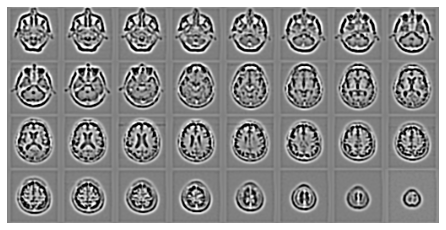

In [ ]:
#load an image, change preprocess in the function above in order to visualize the changes
img = process_scan(AD_scan_paths[10])
plot_slices(4, 8, 64, 64, img[:, :, :])

Dimension of the CT scan is: (64, 64, 32, 1)


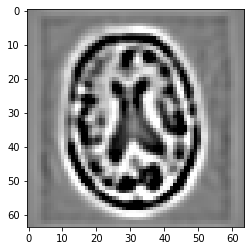

In [ ]:
#visualize data contained in the loaded dataset
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 18]), cmap="gray")

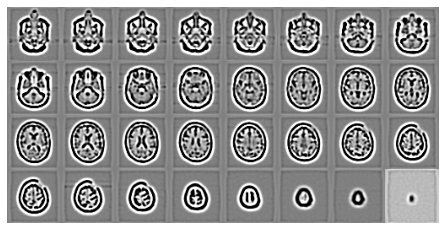

In [ ]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]

plot_slices(4, 8, 64, 64, image[:, :, :])

# Models

In [ ]:
#simple seq model
def get_model(width=64, height=64, depth=64):
    """Build a 3D convolutional neural network model mbased on VGG16."""

    model = models.Sequential()
    model.add(Conv3D(input_shape=(width, height, depth, 1),filters=64,kernel_size=(3,3,3),padding="same", activation="relu"))
    model.add(Conv3D(filters=32,kernel_size=(3,3,3),padding="same", activation="relu"))
    model.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))
    model.add(Conv3D(filters=64, kernel_size=(3,3,3), padding="same", activation="relu"))
    #model.add(Conv3D(filters=64, kernel_size=(3,3,3), padding="same", activation="relu"))
    model.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))
    model.add(Conv3D(filters=128, kernel_size=(3,3,3), padding="same", activation="relu"))
    model.add(Conv3D(filters=128, kernel_size=(3,3,3), padding="same", activation="relu"))
    #model.add(Conv3D(filters=128, kernel_size=(3,3,3), padding="same", activation="relu"))
    #model.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))
    #model.add(Conv3D(filters=128, kernel_size=(3,3,3), padding="same", activation="relu"))
    #model.add(Conv3D(filters=128, kernel_size=(3,3,3), padding="same", activation="relu"))
    #model.add(Conv3D(filters=128, kernel_size=(3,3,3), padding="same", activation="relu"))
    #model.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))
    #model.add(Conv3D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    #model.add(Conv3D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    #model.add(Conv3D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    #model.add(MaxPool3D(pool_size=(2,2),strides=(2,2)))

    model.add(GlobalAveragePooling3D())
    #model.add(Dense(units=256,activation="relu"))
    model.add(Dense(units=128,activation="relu"))
    model.add(Dense(units=3, activation="softmax"))

    model.compile(loss= keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.00001,amsgrad=True),
            metrics=['accuracy']
            )
      
    return model

# Build model.
model = get_model(width=64, height=64, depth=64)
model.summary()

In [ ]:
#original residual model

def res_identity(x, filters): 

  x_skip = x 
  f1, f2 = filters

  x = Conv3D(f1, kernel_size=(1, 1, 1), strides=(1, 1,1),groups=3)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)

  x = Conv3D(int(2*f1), kernel_size=(3, 3,3), strides=(1, 1,1), padding='same',groups=3)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)
  x = Conv3D(int(f1/2), kernel_size=(1, 1,1), strides=(1, 1,1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Conv3D(int(2*f1), kernel_size=(1, 1,1), strides=(1, 1,1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.softmax)(x)

  x = Conv3D(f2, kernel_size=(1,1, 1), strides=(1,1, 1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)

  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x


def res_conv1(x, filters):

  x_skip = x
  f1, f2 = filters

  x = Conv3D(f1, kernel_size=(1,1, 1), strides=(1,1, 1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)

  x = Conv3D(int(2*f1), kernel_size=(3,3, 3), strides=(1,1, 1), padding='same',groups=3)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)
  x = Conv3D(int(f1/2), kernel_size=(1,1, 1), strides=(1,1, 1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Conv3D(int(2*f1), kernel_size=(1,1, 1), strides=(1,1, 1))(x)
  x = Activation(activations.softmax)(x)

  x = Conv3D(f2, kernel_size=(1,1, 1), strides=(1,1, 1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)

  x_skip = AveragePooling3D(pool_size=(1,1,1), strides=(1,1,1),padding='valid')(x_skip)
  x_skip = Conv3D(f2, kernel_size=(1, 1,1), strides=(1, 1,1))(x_skip)
  x_skip = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x_skip)

  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x


def res_conv2(x, filters):
  #split att block
  x_skip = x
  f1, f2 = filters

  x = Conv3D(f1, kernel_size=(1, 1,1), strides=(1,1, 1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = AveragePooling3D(pool_size=(3,3,3), strides=(1,1,1), padding='same')(x)

  x = Conv3D(int(2*f1), kernel_size=(3,3, 3), strides=(1,1, 1), padding='same',groups=3)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)
  x = Conv3D(int(f1/2), kernel_size=(1, 1,1), strides=(1, 1,1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Conv3D(int(2*f1), kernel_size=(1, 1,1), strides=(1, 1,1))(x)
  x = Activation(activations.softmax)(x)

  x = Conv3D(f2, kernel_size=(1, 1,1), strides=(1, 1,1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)

  x_skip = AveragePooling3D(pool_size=(1,1,1), strides=(1,1,1),padding='valid')(x_skip)
  x_skip = Conv3D(f2, kernel_size=(1, 1,1), strides=(1,1, 1))(x_skip)
  x_skip = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x_skip)

  #if ( x.shape != x_skip.shape): print(x.shape,x_skip.shape)
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x


def myResNest():

  input_im = Input(shape= (64, 64,32, 1))
  
  x = ZeroPadding3D(padding=(3,3, 3))(input_im)

  x = Conv3D(32, kernel_size=(3,3, 3), strides=(1,1,1),padding ='same', use_bias= False)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)

  x = Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1, 1),padding ='same', use_bias= False)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)

  x = Conv3D(32, kernel_size=(3,3, 3), strides=(1,1, 1),padding ='same', use_bias= False)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling3D((3, 3,3), strides=(2,2, 2),padding='same')(x)


  x = res_conv1(x, filters=(33, 129))
  x = res_identity(x, filters=(33, 129))
  x = res_identity(x, filters=(33, 129))

  x = res_conv2(x, filters=(66, 258))
  x = res_identity(x, filters=(66, 258))
  x = res_identity(x, filters=(66, 258))
  x = res_identity(x, filters=(66, 258))

  #x = res_conv2(x, filters=(128, 512))
  #x = res_identity(x, filters=(128, 512))
  #x = res_identity(x, filters=(128, 512))
  #x = res_identity(x, filters=(128, 512))
  #x = res_identity(x, filters=(256, 512))
  #x = res_identity(x, filters=(256, 512))

  #x = res_conv2(x, filters=(512, 2048))
  #x = res_identity(x, filters=(512, 2048))
  #x = res_identity(x, filters=(512, 2048))


  x = GlobalAveragePooling3D()(x)
  x = Dense(64, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = Dense(3, activation= 'softmax')(x)


  model = models.Model(inputs=input_im, outputs=x)

  initial_learning_rate = 0.00001
  lr_schedule = keras.optimizers.schedules.ExponentialDecay( 
      initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
      )

  model.compile(loss= keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule,amsgrad=True),
              metrics=['accuracy']
              )


  return model
model = myResNest()
model.summary()
#plot_model(model, show_shapes=True, to_file='residual_module.png')

In [ ]:
#simplified residual model 

def res_identity(x, filters): 

  x_skip = x 
  f1 = filters

  x = Conv3D(f1, kernel_size=(1, 1, 1), strides=(1, 1,1),groups=3)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)

  x = Conv3D(int(f1), kernel_size=(3, 3,3), strides=(1, 1,1), padding='same',groups=3)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)
  x = Conv3D(int(f1/2), kernel_size=(1, 1,1), strides=(1, 1,1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Conv3D(int(f1), kernel_size=(1, 1,1), strides=(1, 1,1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.softmax)(x)

  x = Conv3D(f1, kernel_size=(1,1, 1), strides=(1,1,1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)

  x = Add()([x, x_skip])
  #x = Activation(activations.relu)(x)

  return x


def res_conv1(x, filters):

  x_skip = x
  f1 = filters

  x = Conv3D(f1, kernel_size=(1,1, 1), strides=(1,1, 1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)

  x = Conv3D(int(f1), kernel_size=(3,3, 3), strides=(1,1, 1), padding='same',groups=3)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)
  x = Conv3D(int(f1/2), kernel_size=(1,1, 1), strides=(1,1, 1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Conv3D(int(f1), kernel_size=(1,1, 1), strides=(1,1, 1))(x)
  x = Activation(activations.softmax)(x)

  #x = Conv3D(f2, kernel_size=(1,1, 1), strides=(1,1, 1))(x)
  #x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  #x = Activation(activations.relu)(x)

  x_skip = AveragePooling3D(pool_size=(1,1,1), strides=(1,1,1),padding='same')(x_skip)
  x_skip = Conv3D(f1, kernel_size=(1, 1,1), strides=(1, 1,1))(x_skip)
  x_skip = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x_skip)

  x = Add()([x, x_skip])
  #x = Activation(activations.relu)(x)

  return x


def res_conv2(x, filters):
  #split att block
  x_skip = x
  f1 = filters

  x = Conv3D(f1, kernel_size=(1, 1,1), strides=(1,1, 1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = AveragePooling3D(pool_size=(3,3,3), strides=(2,2,2), padding='same')(x)

  x = Conv3D(int(f1), kernel_size=(3,3, 3), strides=(1,1, 1), padding='same',groups=3)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)
  x = Conv3D(int(f1/2), kernel_size=(1, 1,1), strides=(1, 1,1))(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Conv3D(int(f1), kernel_size=(1, 1,1), strides=(1, 1,1))(x)
  x = Activation(activations.softmax)(x)

  #x = Conv3D(f2, kernel_size=(1, 1,1), strides=(1, 1,1))(x)
  #x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  #x = Activation(activations.relu)(x)

  x_skip = AveragePooling3D(pool_size=(1,1,1), strides=(2,2,2),padding='same')(x_skip)
  x_skip = Conv3D(f1, kernel_size=(1,1,1), strides=(1,1, 1))(x_skip)
  x_skip = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x_skip)

  x = Add()([x, x_skip])
  #x = Activation(activations.relu)(x)

  return x


def myResNest():

  input_im = Input(shape= (64, 64,32, 1))
  
  x = ZeroPadding3D(padding=(3,3, 3))(input_im)

  x = Conv3D(15, kernel_size=(3,3, 3), strides=(1,1,1),padding ='same', use_bias= False)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)

  x = Conv3D(30, kernel_size=(3, 3, 3), strides=(1,1, 1),padding ='same', use_bias= False)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)

  x = Conv3D(15, kernel_size=(3,3, 3), strides=(1,1, 1),padding ='same', use_bias= False)(x)
  x = BatchNormalization(epsilon=1e-05,momentum= 0.1)(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling3D((3, 3,3), strides=(2,2, 2),padding='same')(x)


  x = res_conv1(x, filters=30)
  x = res_identity(x, filters=30)
  x = res_identity(x, filters=30)

  x = res_conv2(x, filters=60)
  x = res_identity(x, filters=60)
  x = res_identity(x, filters=60)
  x = res_identity(x, filters=60)
  
  #x = res_conv2(x, filters=132)
  #x = res_identity(x, filters=132)
  #x = res_identity(x, filters=132)
  #x = res_identity(x, filters=132)
  #x = res_identity(x, filters=132)
  #x = res_identity(x, filters=132)



  x = GlobalAveragePooling3D()(x)
  x = Dense(30, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = Dense(3, activation= 'softmax')(x)


  model = models.Model(inputs=input_im, outputs=x)

  initial_learning_rate = 0.00001
  lr_schedule = keras.optimizers.schedules.ExponentialDecay( 
      initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
      )

  model.compile(loss= keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule,amsgrad=True),
              metrics=['accuracy']
              )


  return model
model = myResNest()
model.summary()
#plot_model(model, show_shapes=True, to_file='residual_module.png')

# Training

In [ ]:
# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/EAI-2131/final.h5", save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience= 1000)

# Train the model, doing validation at the end of each epoch
epochs = 50
history= model.fit(
    train_dataset,
    validation_data=validation_dataset,
    initial_epoch=0,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plot_accuracy_mok')
plt.show()


# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plot_loss_mok')
plt.show()

# Test

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


In [ ]:
#change _400 and _800 in order to load 400 tensors or 800 tensors MRI for training the network 
x_test = np.load('/content/drive/MyDrive/3DCNN_AD/DATASET/Test_Set/test_64x64x32_loG/x_test.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')
y_test = np.load('/content/drive/MyDrive/3DCNN_AD/DATASET/Test_Set/test_64x64x32_loG/y_test.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')


In [ ]:
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))


batch_size = 8
test_dataset = (
    test_loader.shuffle(len(x_test))
    .batch(batch_size)
    .prefetch(2)
)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/3DCNN_AD_0/Results/models/maybe_1.h5')

In [ ]:
model.evaluate(test_dataset)

57/57 [==============================] - 50s 369ms/step - loss: 1.1158 - accuracy: 0.4111


[1.1158498525619507, 0.41111111640930176]

In [ ]:
y_pred = []

for i in range(len(x_test)):
  pred = model.predict(np.reshape(x_test[i],(1,64,64,32,1)),batch_size=1)[0]
  if (pred[0] > pred[1] and pred[0] > pred[2]):
    y_pred.append([1,0,0])
  elif (pred[1] > pred[0] and pred[1] > pred[2]):
    y_pred.append([0,1,0])
  else:
    y_pred.append([0,0,1])
 

In [ ]:
y_pred = np.array(y_pred)

In [ ]:
confusion = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)


Confusion Matrix

[[57 41 52]
 [40 87 73]
 [20 39 41]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[57 41 52]
 [40 87 73]
 [20 39 41]]


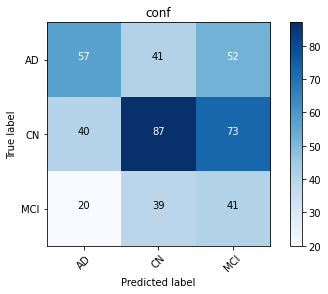

In [ ]:
plot_confusion_matrix(confusion,['AD','CN','MCI'],title='conf')